In [1]:
from sklearn.neural_network import MLPClassifier as mlp
import sys
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML")
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML/FeH")
from fitsParser.fitsParser import fitsParser
import pandas as pd
import numpy as np
from numpy import linspace
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from modelValidator import psMetric, cut, shuffleDwarfs, plotRes, plot, norm_inputs, monte_carlo, printTable
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from function import save_data
from sklearn.preprocessing import LabelEncoder

fits = fitsParser(includefile = 'fitsSetup.txt')
fits.data['u'] += 0.4 
fits.makeColours(N=10)
colours = [ 'g-i', 'CaHK-g', 'u-g', 'CaHK-g', 'CaHK-i', 'z-y', 'u-CaHK']
test_colours = ['pristine_col', 'g-i','u-CaHK', 'g-r', 'pristine_col2']
fits.data['pristine_col'] = fits.data['CaHK-g']
fits.data['pristine_col2'] = fits.data['CaHK-r']
sdss = fitsParser(includefile = 'FeHdata.txt')
colours = fits.colours
#compensate for percent level offset in ab magnitudes from sdss
def getMags(colour):
    return colour[:colour.index('-')], colour[colour.index('-')+1:]


youc = sdss.getAllObj()[1]

cut(youc, metThresh = -5)
youc.makeColours(N=10)
conversion = {
     'u_0' : 'u',
    'CaHK_0' : 'CaHK' 
}
conversion.update({x+'_fpsf' : x for x in 'grizy'})
for col in youc.colours:
    mag1, mag2 = getMags(col)
    youc.data[conversion[mag1]+'-'+conversion[mag2]] = youc.data[col]


for field in youc.data.keys():
    if field in conversion:
        youc.data[conversion[field]]= youc.data[field]
    
youc.data['pristine_col'] = youc.data['CaHK-g'] 
youc.data['pristine_col2'] = youc.data['CaHK-r']
youc.data['FeHround'] = [-3 if x<=-2.75 else -2.5 if x<=-2.5 else -2 for x in youc.data['FeHadop'] ]
data = pd.DataFrame(youc.data)
data = shuffle(data)
#data[fits.colours] += np.random.normal(scale = 0.1, size = (len(data),len(fits.colours)))
#data['FeH'] += np.random.normal(scale = 0.15, size = len(data))
nn = True
train_in, test_in, train_out, test_out = train_test_split(data[colours], data['FeHround'], test_size = 0.2 if nn else 0.7, shuffle = False)
data['test_flag'] = [0]*len(train_in)+[1]*len(test_in)

Using TensorFlow backend.



Data saved

condition on dFeHadop cut 17 inputs
2.99% of inputs cut


In [2]:
params = {
        'hidden_layer_sizes' : (64,64,64,64,64),
        'max_iter' : 500, 
        'verbose' : True,
        'batch_size' :25,
        'tol' : 0
    }
encoder = LabelEncoder()
labels = encoder.fit_transform(np.ravel(train_out))
model = mlp(**params)
model.fit(train_in.values, labels)

Iteration 1, loss = 0.94640984
Iteration 2, loss = 0.90675651
Iteration 3, loss = 0.90276177
Iteration 4, loss = 0.89671311
Iteration 5, loss = 0.89004686
Iteration 6, loss = 0.91985891
Iteration 7, loss = 0.91143812
Iteration 8, loss = 0.89302320
Iteration 9, loss = 0.89199800
Iteration 10, loss = 0.89558131
Iteration 11, loss = 0.87949987
Iteration 12, loss = 0.87484318
Iteration 13, loss = 0.86087076
Iteration 14, loss = 0.85094977
Iteration 15, loss = 0.88071764
Iteration 16, loss = 0.85388660
Iteration 17, loss = 0.84435969
Iteration 18, loss = 0.86627358
Iteration 19, loss = 0.88301619
Iteration 20, loss = 0.83535569
Iteration 21, loss = 0.82509179
Iteration 22, loss = 0.84630133
Iteration 23, loss = 0.85495028
Iteration 24, loss = 0.81259453
Iteration 25, loss = 0.82252182
Iteration 26, loss = 0.80347335
Iteration 27, loss = 0.79487210
Iteration 28, loss = 0.80297330
Iteration 29, loss = 0.79488851
Iteration 30, loss = 0.81855610
Iteration 31, loss = 0.84853594
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size=25, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 64, 64, 64, 64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0,
       validation_fraction=0.1, verbose=True, warm_start=False)

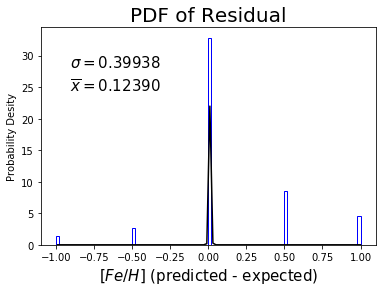

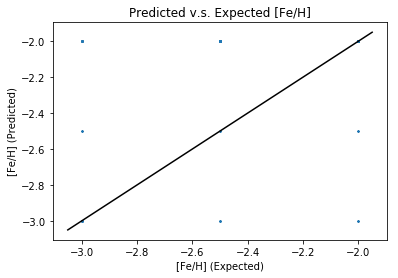

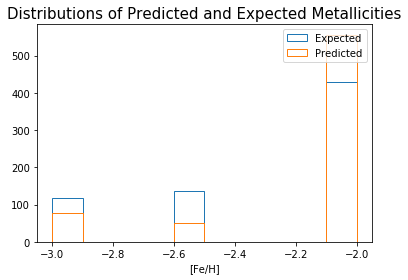

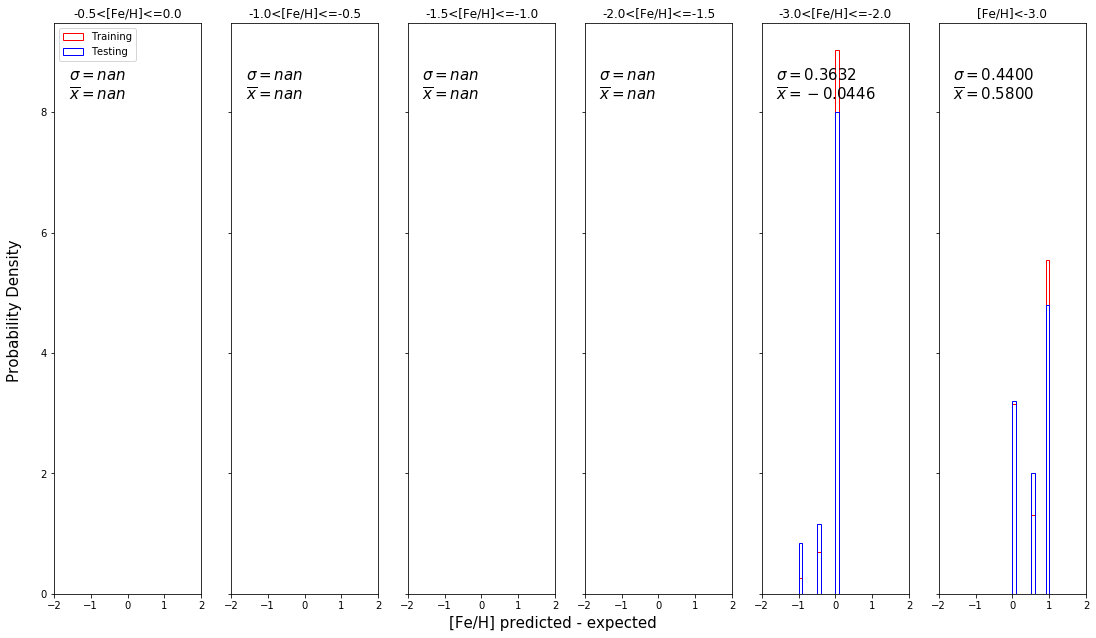

| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.7302 | 0.3622      |
| -3.0    | 0.2895 | 0.4783      |



[[0.9205607476635514, 0.037383177570093455, 0.04205607476635514],
 [0.7226277372262774, 0.12408759124087591, 0.15328467153284672],
 [0.5384615384615384, 0.1452991452991453, 0.3162393162393162]]

| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.6176 | 0.4200      |
| -3.0    | 0.1818 | 0.4444      |



[[0.8505747126436781, 0.05747126436781609, 0.09195402298850575],
 [0.68, 0.08, 0.24],
 [0.48, 0.2, 0.32]]

In [6]:

data['FeH_pred'] = encoder.inverse_transform(model.predict(data[colours]))
data['res'] = data['FeH_pred'] - data['FeHround']
#plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plot(data['res'])


def makePlots(outputSDSS, pred = 'FeH_pred', adop = 'FeHadop', res ='res'):
    #plot((outputSDSS[res])[outputSDSS['test_flag']==-1])

    plt.scatter(outputSDSS[adop], outputSDSS[pred] , s = 0.5)
    plt.title('Predicted v.s. Expected [Fe/H]')
    plt.xlabel('[Fe/H] (Expected)')
    plt.ylabel('[Fe/H] (Predicted)')
    x = np.linspace(max((plt.xlim())[0], (plt.ylim())[0]), min((plt.xlim())[1], (plt.ylim())[1]))
    plt.plot(x,x, color = 'black')
    plt.show()


    getbins = lambda data, size = 0.1 : np.arange(min(data), max(data) + size, size)
    den = False
    getNbins = lambda data, s ,size = 0.1 : int((np.max(data[s])-np.min(data[s]))/size)
    try:
        plt.hist((outputSDSS[pred])[outputSDSS['test_flag']==-1], bins  = getbins((outputSDSS[pred])[outputSDSS['test_flag']==-1]),  histtype = 'step', label = 'Predicted | [Fe/H]>%.1f'%metCut, density = den)
    except ValueError:
        pass
    plt.hist((outputSDSS[adop]), bins = getbins((outputSDSS[adop])), histtype = 'step', label = 'Expected', density = den)
    plt.hist((outputSDSS[pred])[outputSDSS['test_flag']>=0], bins=getbins((outputSDSS[pred])[outputSDSS['test_flag']>=0]),  histtype = 'step', label = 'Predicted', density = den)
    plt.xlabel('[Fe/H]')
    plt.title('Distributions of Predicted and Expected Metallicities', fontsize = 15)
    plt.legend(loc = 'upper right')
    plt.show()


    bins = [0, -0.5, -1,-1.5, -2 , -3]
    f,  z = plt.subplots(1, len(bins), sharex='all', sharey='row')
    plt.xlim(-2,2)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(bins)):
        if (i==len(bins)-1):
            sub = outputSDSS[outputSDSS[adop]<=bins[i]]
        else:
            sub = outputSDSS[(outputSDSS[adop]<=bins[i])&(outputSDSS[adop]>bins[i+1])]
        Title = '%.1f<[Fe/H]<=%.1f' %(bins[i+1] ,bins[i]) if i+1 in range(len(bins)) else '[Fe/H]<%.1f'%bins[i]
        plotRes((sub[sub['test_flag']!=0])[res], (sub[sub['test_flag']==0][res]), toPlot = z[i],title = Title, normalFit = False, xy = (0.1 , 0.9))
    z[0].legend(loc = 'upper left')
    f.text(0.5, 0.08, '[Fe/H] predicted - expected', ha='center', fontsize = 15)
    f.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 15)
    plt.show()
    
makePlots(data, adop = 'FeHround')
i = [-2,-2.5, -3]
pur, com = psMetric(data, inc = i)
print printTable(i, pur, com)
def conf_matrix(data, classes):
    return [[len(data[(data['FeHround']==c1)&(data['FeH_pred']==c2)])*1.0/len(data[(data['FeHround']==c1)])
             if len(data[(data['FeHround']==c1)])!= 0 else -1
             for c2 in classes] for c1 in classes]
m = conf_matrix(data, i)    
display(m)

d2= data[data['test_flag']==1]
pur2, com2 = psMetric(d2, inc =i)
print printTable(i, pur2,com2)
display(conf_matrix(d2,i))